In [2]:
%load_ext autoreload
%autoreload 2
%cd code

c:\Users\xavid\Documents\GitHub\Clustering-Algorithms\code


In [7]:
from preprocessing import preprocess_sick, preprocess_grid, preprocess_vehicle
from utils import plot_clusters

import pandas as pd


In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Define distance metrics
def euclidean_distance(X, centers):
    # Expand shapes for broadcasting (n_samples, 1, n_features) vs (k, n_features)
    distances = np.linalg.norm(X[:, np.newaxis] - centers, axis=2)
    return distances

def manhattan_distance(X, centers):
    # Expand shapes for broadcasting (n_samples, 1, n_features) vs (k, n_features)
    distances = np.sum(np.abs(X[:, np.newaxis] - centers), axis=2)
    return distances

def cosine_similarity(X, centers):
    # Normalize data and centers
    norm_X = np.linalg.norm(X, axis=1)[:, np.newaxis]
    norm_centers = np.linalg.norm(centers, axis=1)
    similarity = np.dot(X, centers.T) / (norm_X * norm_centers)  # Cosine similarity
    return 1 - similarity  # Return 1 - cosine similarity for clustering

# K-Means implementation
def k_means(data, centers, k, distance_metric, max_iters=100, tolerance=1e-4):
    
    for iteration in range(max_iters):
        # Assignment step: Compute distances and assign points to the nearest cluster
        distances = distance_metric(data, centers)
        cluster_ids = np.argmin(distances, axis=1)

        # Update step: Compute new centers as the mean of points assigned to each cluster
        new_centers = np.array([data[cluster_ids == i].mean(axis=0) if len(data[cluster_ids == i]) > 0 else centers[i]
                               for i in range(k)])

        # Check for convergence
        center_shift = np.sum(np.linalg.norm(new_centers - centers, axis=1))
        if center_shift < tolerance:
            break

        centers = new_centers

    # Assign points to clusters
    clusters = {i: {'points': data[cluster_ids == i], 'center': centers[i]} for i in range(k)}
    return clusters

# Plotting function
def plot_clusters(clusters):
    plt.figure(figsize=(8, 6))

    for cluster_id, cluster_data in clusters.items():
        points = np.array(cluster_data['points'])
        center = cluster_data['center']

        if len(points) > 0:
            plt.scatter(points[:, 0], points[:, 1], label=f'Cluster {cluster_id} Points', alpha=0.6, s=30)

        plt.scatter(center[0], center[1], color='red', marker='X', s=100, label=f'Cluster {cluster_id} Center')

    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title('Cluster Points and Centers')
    plt.legend()
    plt.grid(True)
    plt.show()


In [9]:
df = pd.read_csv('../datasets_processed/grid.csv')
df_X = np.array(df[df.columns[:-1]])
df_y = np.array(df[df.columns[-1]])

In [10]:
n_samples, n_features = df_X.shape

# Randomly initialize cluster centers
np.random.seed(42)
initial_indices = np.random.choice(n_samples, 3, replace=False)
centers = df_X[initial_indices]

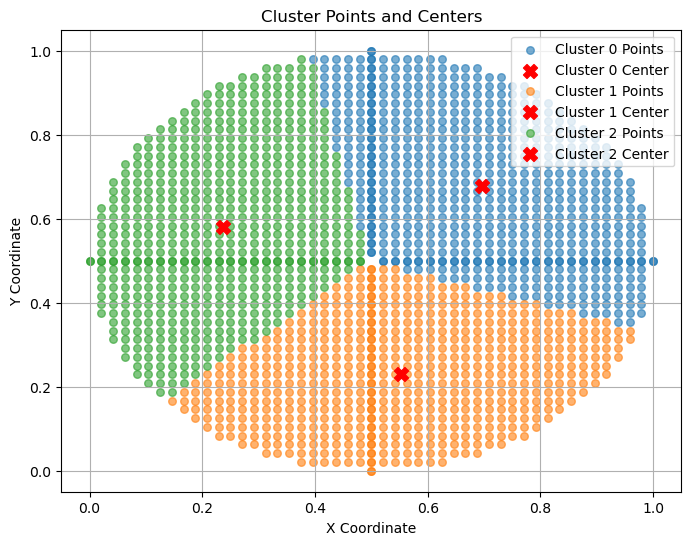

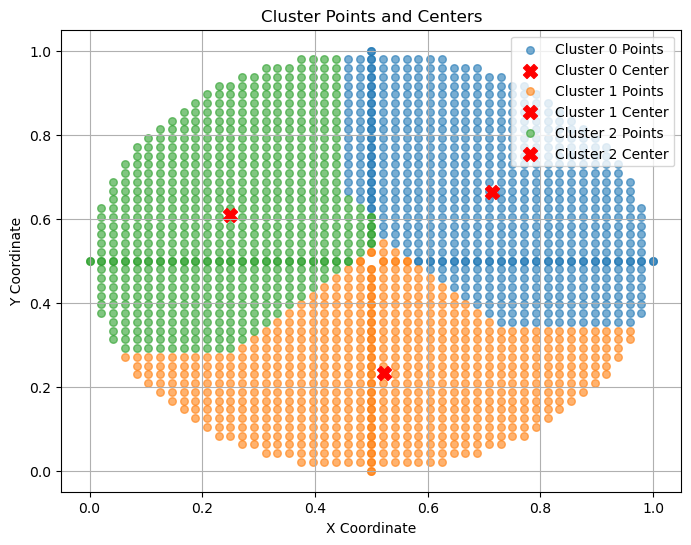

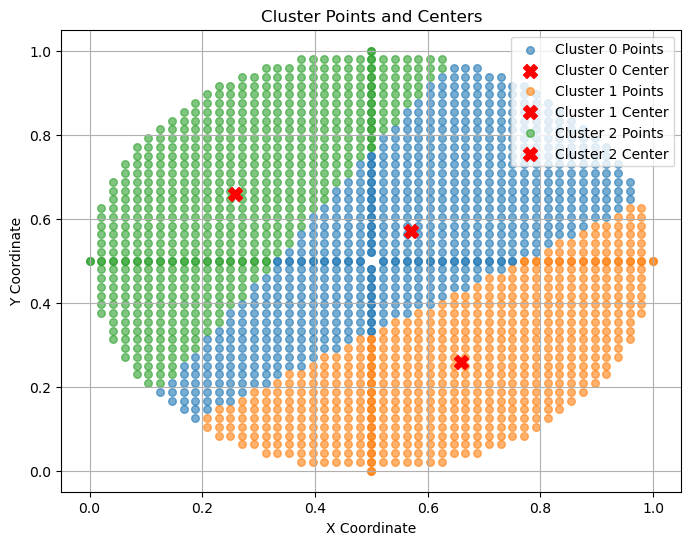

In [48]:
# Test with Euclidean distance, k=3
clusters_euclidean = k_means(df_X, centers = centers, k=3, distance_metric=euclidean_distance)
plot_clusters(clusters_euclidean)

# Test with Manhattan distance, k=3
clusters_manhattan = k_means(df_X, centers = centers,k=3, distance_metric=manhattan_distance)
plot_clusters(clusters_manhattan)

# Test with Cosine similarity, k=3
clusters_cosine = k_means(df_X, centers = centers,k=3, distance_metric=cosine_similarity)
plot_clusters(clusters_cosine)

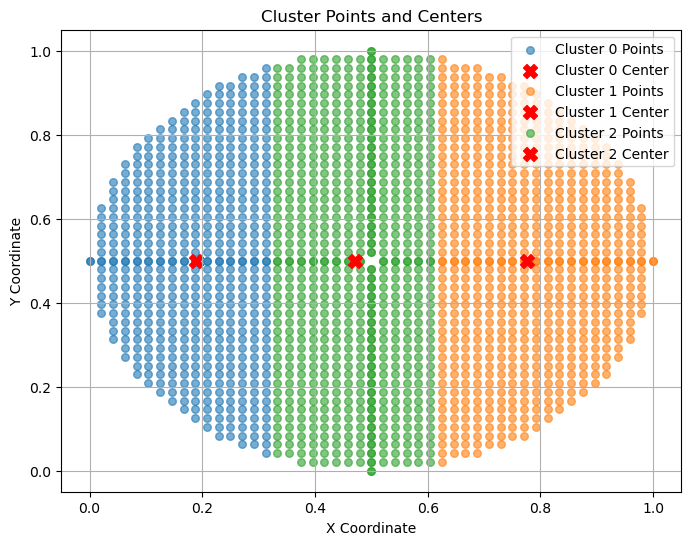

In [14]:
def proposed_initialization_FNC(data, k, distance_metric):
    """
    Initialization method for KMeans:
    Selects the first center based on the smallest value on the first axis.
    Subsequent centers are chosen based on a custom weighting formula.
    """
    n_samples = data.shape[0]
    centers = []

    # Step 1: Select the first center as the point with the smallest value on the first axis
    first_center_idx = np.argmin(data[:, 0])
    centers.append(data[first_center_idx])

    # Step 2: Iteratively select the next k-1 centers
    for _ in range(1, k):
        max_score = -np.inf
        next_center = None

        for i, P in enumerate(data):
            # Skip if the point is already a center
            if any(np.allclose(P, center) for center in centers):
                continue

            # Compute distances from P to all current centers
            distances = np.array([distance_metric(P[np.newaxis, :], np.array([center]))[0][0] for center in centers])
            
            # Useful Nearest Centers of P (UNCP)
            UNCP = [c for j, c in enumerate(centers) if distances[j] > 0]  # Exclude 0-distance (useless center)

            # Skip if UNCP is empty
            if len(UNCP) == 0:
                continue

            # Compute the weighted score for P
            avg_distance = np.mean(distances)
            max_distance = np.max(distances)
            log_sum = np.sum(np.log(distances + 1e-10))  # Avoid log(0) with a small constant
            score = max_distance / log_sum

            # Update the candidate center if the score is higher
            if score > max_score:
                max_score = score
                next_center = P

        # Add the chosen point as the next center
        centers.append(next_center)

    return np.array(centers)

# Define the number of clusters
k = 3

# Initialize centers using the proposed method
initial_centers = proposed_initialization_FNC(df_X, k, euclidean_distance)

# Run K-Means using the initialized centers
clusters_proposed = k_means(df_X, initial_centers, k, euclidean_distance)
plot_clusters(clusters_proposed)

In [17]:

# Function to calculate the SSEDM (Squared Sum of Euclidean Distance Metric) for a given solution
def ssedm(data, clusters):
    ssedm_value = 0
    for cluster in clusters.values():
        center = cluster['center']
        points = cluster['points']
        ssedm_value += np.sum(np.linalg.norm(points - center, axis=1) ** 2)
    return ssedm_value

# Function to calculate Gain for a given cluster
def calculate_gain(cluster, data):
    # Placeholder for actual Gain calculation logic
    # The Gain value can be a measure of how separable the cluster is based on distance to other clusters
    return np.sum(np.linalg.norm(cluster['points'] - cluster['center'], axis=1))

# Function to calculate Cost for a given cluster (pairing cost with another cluster)
def calculate_cost(cluster_i, cluster_j, data):
    # Placeholder for actual Cost calculation logic
    # The Cost value could be based on the proximity of centers or overlap of points between the two clusters
    return np.sum(np.linalg.norm(cluster_i['points'] - cluster_j['center'], axis=1))

# Function to update the center of a cluster (move center to a random point within the cluster)
def update_center(cluster, data):
    random_point_idx = np.random.choice(cluster['points'].shape[0])
    new_center = cluster['points'][random_point_idx]
    cluster['center'] = new_center

# I-k-means-+ implementation
def ik_means_plus(data, k, distance_metric, max_iters=100, tolerance=1e-4):

    
    # Instruction 1
    initial_centers = proposed_initialization_FNC(data, k, distance_metric)
    clusters = k_means(data, initial_centers, k, distance_metric)
    
    # Instruction 2 
    success = 0

    while True:
        # Instruction 3
        gains = {i: calculate_gain(cluster, data) for i, cluster in clusters.items()}
        max_gain = max(gains, key=gains.get)
        max_gain_cluster_id = max_gain
        max_gain_cluster = clusters[max_gain_cluster_id]
        
        # Instruction #3: If no valid cluster with Gain, stop
        if max_gain_cluster is None:
            break
        
        print(gains)


        # Find a valid pair (S_i, S_j) based on the provided conditions
        cost_values = {i: calculate_cost(max_gain_cluster, clusters[i], data) for i in clusters if i != max_gain_cluster_id}
        valid_pair = min(cost_values, key=cost_values.get)
        
        if valid_pair is None:
            break
        
        # Instruction #7: Save solution and attempt to divide the selected cluster
        prev_clusters = clusters.copy()
        update_center(clusters[max_gain_cluster_id], data)
        
        # Apply t-k-means (reapply k-means after splitting)
        new_clusters = k_means(data, k, distance_metric)  # Assuming t-k-means is the same as standard k-means for now

        # Check improvement (SSEDM comparison)
        if ssedm(data, new_clusters) > ssedm(data, prev_clusters):
            # No improvement, mark clusters as unmatchable
            success += 1
            break
        else:
            # Improvement: Mark clusters and continue refining
            success += 1
            clusters = new_clusters

    return clusters

# Plotting function for I-k-means-+ result
def plot_clusters_ikmeans(clusters):
    plt.figure(figsize=(8, 6))

    for cluster_id, cluster_data in clusters.items():
        points = np.array(cluster_data['points'])
        center = cluster_data['center']

        if len(points) > 0:
            plt.scatter(points[:, 0], points[:, 1], label=f'Cluster {cluster_id} Points', alpha=0.6, s=30)

        plt.scatter(center[0], center[1], color='red', marker='X', s=100, label=f'Cluster {cluster_id} Center')

    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title('Cluster Points and Centers (I-k-means-+)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Now let's test with the existing data
df = pd.read_csv('../datasets_processed/grid.csv')
df_X = np.array(df[df.columns[:-1]])
df_y = np.array(df[df.columns[-1]])

# Apply I-k-means-+ with Euclidean distance
clusters = ik_means_plus(df_X, k=3, distance_metric=euclidean_distance)
plot_clusters_ikmeans(clusters)

# Apply I-k-means-+ with Manhattan distance
clusters = ik_means_plus(df_X, k=3, distance_metric=manhattan_distance)
plot_clusters_ikmeans(clusters)

# Apply I-k-means-+ with Cosine similarity
clusters = ik_means_plus(df_X, k=3, distance_metric=cosine_similarity)
plot_clusters_ikmeans(clusters)

{0: 107.26397805829916, 1: 148.40846845463065, 2: 186.70013353919916}


TypeError: k_means() missing 1 required positional argument: 'distance_metric'

In [7]:
class CustomKMeans:
    def __init__(self, n_clusters, init=None, max_iters=100, tolerance=1e-4):

        self.n_clusters = n_clusters
        self.init = init
        self.max_iters = max_iters
        self.tolerance = tolerance
        self.centroids = None

    def fit(self, data):

        n_samples, n_features = data.shape

        # Initialize centroids
        if self.init is not None:
            self.centroids = np.array(self.init)
        else:
            np.random.seed(42)
            random_indices = np.random.choice(n_samples, self.n_clusters, replace=False)
            self.centroids = data[random_indices]

        for iteration in range(self.max_iters):
            # Assignment step: Compute distances and assign points to the nearest cluster
            distances = self.euclidean_distance(data, self.centroids)
            cluster_ids = np.argmin(distances, axis=1)

            # Update step: Compute new centers as the mean of points assigned to each cluster
            new_centroids = np.array([
                data[cluster_ids == i].mean(axis=0) if np.any(cluster_ids == i) else self.centroids[i]
                for i in range(self.n_clusters)
            ])

            # Check for convergence
            center_shift = np.sum(np.linalg.norm(new_centroids - self.centroids, axis=1))
            if center_shift < self.tolerance:
                break

            self.centroids = new_centroids

        # Store final cluster assignments and distances
        self.cluster_ids_ = cluster_ids
        self.distances_ = distances

    def predict(self, data):
        distances = self.euclidean_distance(data, self.centroids)
        cluster_ids = np.argmin(distances, axis=1)
        return cluster_ids

    def transform(self, data):
        return self.euclidean_distance(data, self.centroids)
    
    def euclidean_distance(self, X, centers):
        distances = np.linalg.norm(X[:, np.newaxis] - centers, axis=2)
        return distances

In [12]:
import numpy as np
from sklearn.cluster import KMeans

def global_kmeans(X, max_clusters):
    N, d = X.shape
    solutions = []  # Store cluster centers for each k
    
    for k in range(1, max_clusters + 1):
        best_inertia = float('inf')
        best_centers = None

        if k == 1:
            # Start with the centroid of all points for k=1
            initial_center = np.mean(X, axis=0).reshape(1, -1)
            kmeans = CustomKMeans(n_clusters=1, init=initial_center, max_iters=300, tolerance=1e-4)
            kmeans.fit(X)
            solutions.append(kmeans.centroids)
            continue

        for i in range(N):
            # Fix k-1 centers from the previous solution
            fixed_centers = solutions[-1]
            # Add a new cluster center at the position of data point X[i]
            initial_centers = np.vstack([fixed_centers, X[i].reshape(1, -1)])
            kmeans = CustomKMeans(n_clusters=k, init=initial_centers, max_iters=300, tolerance=1e-4)
            kmeans.fit(X)

            # Compare inertia (sum of squared distances to the centroids)
            if np.sum(kmeans.distances_) < best_inertia:
                best_inertia = np.sum(kmeans.distances_)
                best_centers = kmeans.centroids

        # Store the best centroids for this k value
        solutions.append(best_centers)

    return solutions


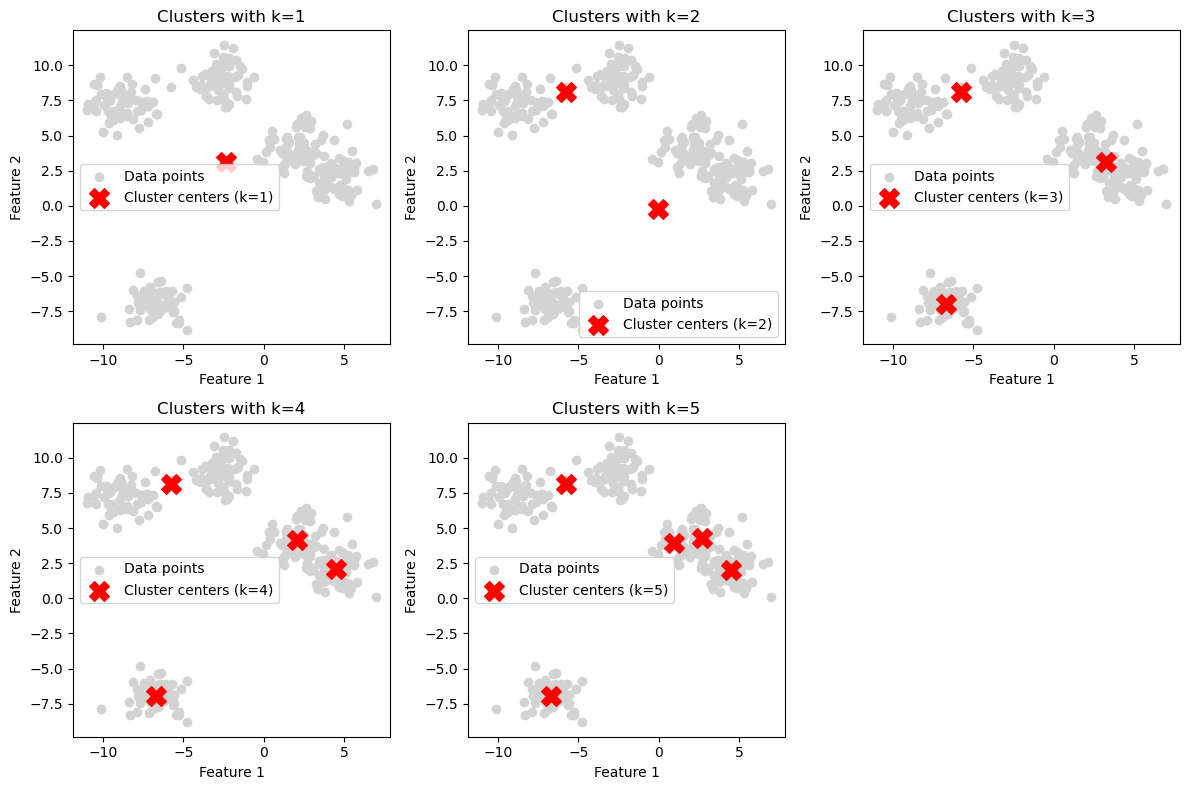

In [13]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
# Generate synthetic dataset
X, _ = make_blobs(n_samples=300, centers=5, random_state=42)

# Perform Fast Global k-Means
solutions = global_kmeans(X, max_clusters=5)

# Plotting the results
plt.figure(figsize=(12, 8))

# Plot for each k from 1 to max_clusters
for k, centers in enumerate(solutions, start=1):
    plt.subplot(2, 3, k)
    plt.scatter(X[:, 0], X[:, 1], c='lightgray', label='Data points')
    plt.scatter(centers[:, 0], centers[:, 1], c='red', label=f'Cluster centers (k={k})', s=200, marker='X')
    plt.title(f"Clusters with k={k}")
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.neighbors import KDTree

def fast_global_kmeans(X, max_clusters, bucket_size=10):
    N, d = X.shape
    solutions = []  # Store cluster centers for each k
    distances_matrix = np.linalg.norm(X[:, np.newaxis] - X, axis=2) ** 2  # Pairwise squared distances
    
    for k in range(1, max_clusters + 1):
        best_inertia = float('inf')
        best_centers = None
        
        if k == 1:
            # Start with the centroid of all points for k=1
            initial_center = np.mean(X, axis=0).reshape(1, -1)
            kmeans = CustomKMeans(n_clusters=1, init=initial_center, max_iters=300, tolerance=1e-4)
            kmeans.fit(X)
            solutions.append(kmeans.centroids)
            continue
        
        best_i = None

        for i in range(N):
            # For each possible insertion position (x_i), calculate the upper bound error (b_n)
            bn = np.zeros(N)
            for j in range(N):
                # Calculate the squared distance to the closest center from the (k-1)-clustering
                closest_center_dist = np.min(np.linalg.norm(X[j] - solutions[-1], axis=1) ** 2)
                bn[j] = max(closest_center_dist - np.linalg.norm(X[i] - X[j]) ** 2, 0)
            
            # Compute the upper bound error for inserting a center at X[i]
            En = np.sum(bn)
            
            if En < best_inertia:
                best_inertia = En
                best_i = i
        
        # Now use the selected best_i to update the cluster centers with k-means
        best_center = X[best_i].reshape(1, -1)
        initial_centers = np.vstack([solutions[-1], best_center])
        kmeans = CustomKMeans(n_clusters=k, init=initial_centers, max_iters=300, tolerance=1e-4)
        kmeans.fit(X)

        # Save the best solution for k clusters
        solutions.append(kmeans.centroids)

    return solutions



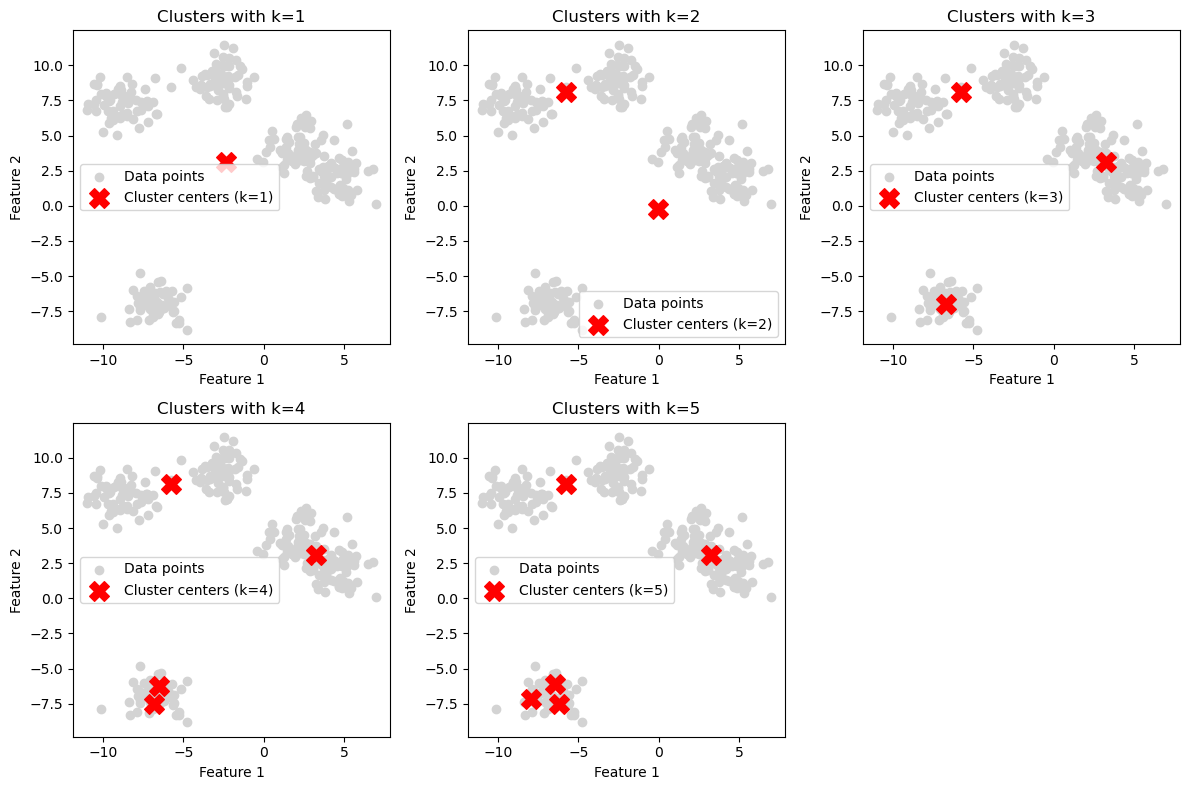

In [11]:
import matplotlib.pyplot as plt
# Generate synthetic dataset
X, _ = make_blobs(n_samples=300, centers=5, random_state=42)

# Perform Fast Global k-Means
solutions = fast_global_kmeans(X, max_clusters=5)

# Plotting the results
plt.figure(figsize=(12, 8))

# Plot for each k from 1 to max_clusters
for k, centers in enumerate(solutions, start=1):
    plt.subplot(2, 3, k)
    plt.scatter(X[:, 0], X[:, 1], c='lightgray', label='Data points')
    plt.scatter(centers[:, 0], centers[:, 1], c='red', label=f'Cluster centers (k={k})', s=200, marker='X')
    plt.title(f"Clusters with k={k}")
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()

plt.tight_layout()
plt.show()